# Setup

In [1]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'monospace'

In [2]:
with open('data/vqa/raw/v2_OpenEnded_mscoco_test2015_questions.json') as f:
    ques = json.load(f)['questions']
print('Number of questions:', len(ques))

with open('results/cache/test_pred_butd.json') as f:
    pred_butd = json.load(f)
assert len(pred_butd) == len(ques)

with open('results/cache/test_pred_ban.json') as f:
    pred_ban = json.load(f)
assert len(pred_ban) == len(ques)

with open('results/cache/test_pred_mcan.json') as f:
    pred_mcan = json.load(f)
assert len(pred_mcan) == len(ques)

Number of questions: 447793


In [3]:
pred_butd_df = pd.DataFrame(pred_butd)
pred_butd_df.columns = ['answer_butd', 'question_id']

pred_ban_df = pd.DataFrame(pred_ban)
pred_ban_df.columns = ['answer_ban', 'question_id']

pred_mcan_df = pd.DataFrame(pred_mcan)
pred_mcan_df.columns = ['answer_mcan', 'question_id']

ques_df = pd.DataFrame(ques)

In [4]:
# remove duplicate columns
pred_df = pd.concat([pred_butd_df, pred_ban_df, pred_mcan_df], axis=1)
pred_df = pred_df.loc[:, ~pred_df.columns.duplicated()]
pred_df.head()

,answer_butd,question_id,answer_ban,answer_mcan
0,yes,262144000,no,no
1,baseball,262144001,baseball,baseball
2,no,262144002,no,yes
3,yes,262144003,yes,yes
4,yes,262144004,yes,no


In [5]:
# merge question with answers
df = pd.merge(pred_df, ques_df, how='inner', on='question_id')
columns = ['image_id', 'question_id', 'question', 'answer_butd', 'answer_ban', 'answer_mcan']
df = df.reindex(columns=columns)
df.head()

,image_id,question_id,question,answer_butd,answer_ban,answer_mcan
0,262144,262144000,Is the ball flying towards the batter?,yes,no,no
1,262144,262144001,What sport is this?,baseball,baseball,baseball
2,262144,262144002,Can you see the ball?,no,no,yes
3,262144,262144003,Is the pitcher wearing a hat?,yes,yes,yes
4,262144,262144004,Will he catch the ball in time?,yes,yes,no


In [6]:
# attention weights
att_weight_butd = np.load('results/cache/att_weight_butd.npz')['att']
att_weight_ban = np.load('results/cache/att_weight_ban.npz')['att']
att_weight_mcan = np.load('results/cache/att_weight_mcan.npz')['att'] / 14.0

In [7]:
# check attention weights
stat = pd.DataFrame({
    'butd': att_weight_butd.sum(axis=1),
    'ban': att_weight_ban.sum(axis=1),
    'mcan': att_weight_mcan.sum(axis=1)
})
stat.agg(['mean', 'var'])

,butd,ban,mcan
mean,1.000000e+00,1.000000e+00,1.000000e+00
var,2.019646e-14,1.461629e-15,4.354493e-16


# Visualization functions

268979


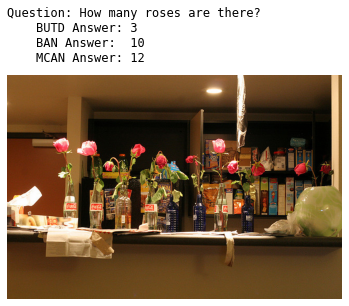

In [9]:
def show_image(image_id, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 6))
    image = plt.imread(f'data/vqa/raw/test2015/COCO_test2015_000000{image_id:06}.jpg')
    ax.imshow(image)

def visualize_ques_ans(row, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    show_image(row['image_id'], ax)

    text = '''Question: {question}
    BUTD Answer: {answer_butd}
    BAN Answer:  {answer_ban}
    MCAN Answer: {answer_mcan}'''.format_map(row)
    ax.text(0, 1.05, text, transform=ax.transAxes, va='bottom', ha='left')
    ax.set_axis_off()

def visualize_ques_ans_random(df, k=5):
    idx = np.random.choice(df.index)
    print(idx)
    visualize_ques_ans(df.loc[idx])
    
visualize_ques_ans_random(df)

298519


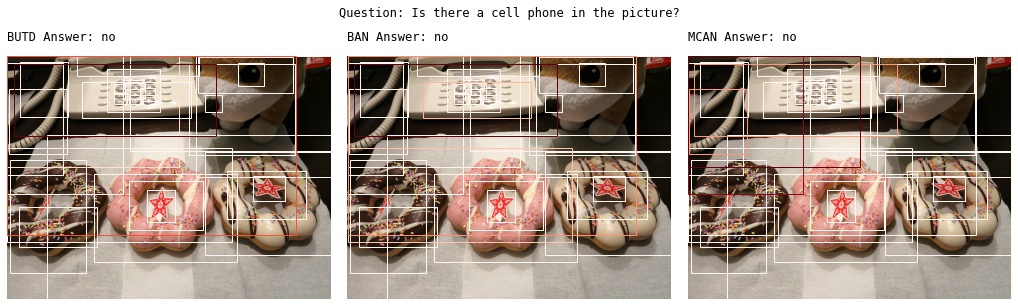

In [10]:
def visualize_bbox(row, k=5):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.text(0.5, 1.15, f'Question: {row["question"]}', transform=axs[1].transAxes, va='bottom', ha='center')
    plt.subplots_adjust(wspace=0.05)
    
    with np.load(f'data/vqa/feats/test2015/COCO_test2015_000000{row["image_id"]:06}.jpg.npz') as npz:
        image_info = dict(zip(npz.files, npz.values()))
        
    keys = ['answer_butd', 'answer_ban', 'answer_mcan']
    atts = [att_weight_butd, att_weight_ban, att_weight_mcan]
    
    for ax, key, att in zip(axs, keys, atts):
        show_image(row['image_id'], ax)
        text = f'{key.split("_")[1].upper()} Answer: {row[key]}'
        ax.text(0, 1.05, text, transform=ax.transAxes, va='bottom', ha='left')
        ax.set_axis_off()
        
        att = att[row.name][:image_info['num_bbox']]
        idx = att.argsort()
        att = att[idx]
        norm = mpl.colors.Normalize()
        cmap = plt.cm.Reds
        norm(att[-k:])
        colors = cmap(norm(att))
        bboxes = image_info['bbox'][idx]
        
        for bbox, color in zip(bboxes, colors):
            x0, y0, x1, y1 = bbox
            bbox_patch = mpl.patches.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor=color)
            ax.add_patch(bbox_patch)

def visualize_bbox_random(df, k=5):
    idx = np.random.choice(df.index)
    print(idx)
    visualize_bbox(df.loc[idx], k)

visualize_bbox_random(df)

97848


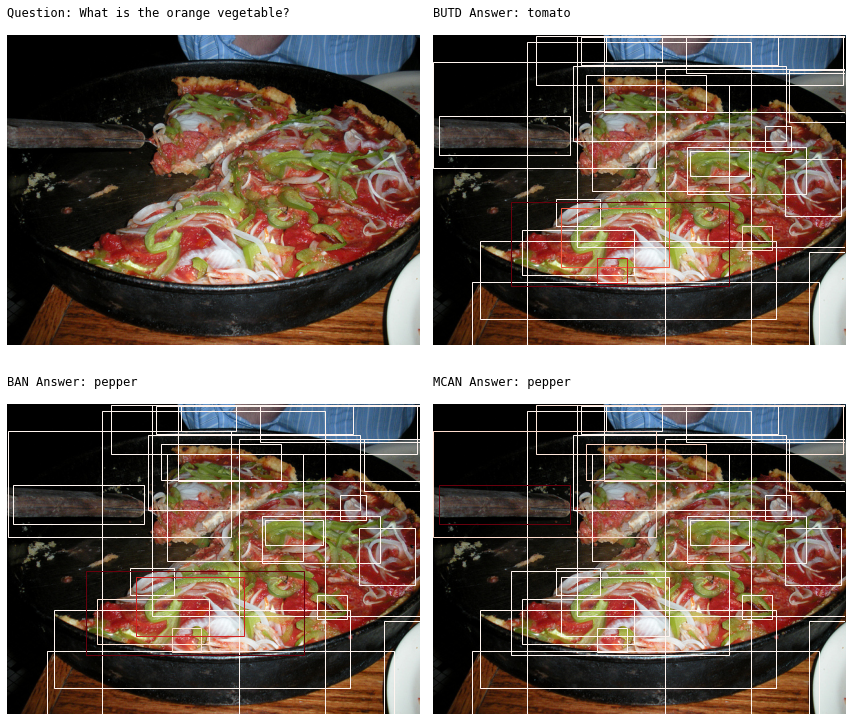

In [11]:
def visualize_bbox_with_original(row, k=5):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.flatten()
    fig.text(0, 1.05, f'Question: {row["question"]}', transform=axs[0].transAxes, va='bottom', ha='left')
    plt.subplots_adjust(wspace=0.05, hspace=0.0)
    
    with np.load(f'data/vqa/feats/test2015/COCO_test2015_000000{row["image_id"]:06}.jpg.npz') as npz:
        image_info = dict(zip(npz.files, npz.values()))
        
    keys = ['answer_butd', 'answer_ban', 'answer_mcan']
    atts = [att_weight_butd, att_weight_ban, att_weight_mcan]
    
    show_image(row['image_id'], axs[0])
    axs[0].set_axis_off()
    
    for ax, key, att in zip(axs[1:], keys, atts):
        show_image(row['image_id'], ax)
        text = f'{key.split("_")[1].upper()} Answer: {row[key]}'
        ax.text(0, 1.05, text, transform=ax.transAxes, va='bottom', ha='left')
        ax.set_axis_off()
        
        att = att[row.name][:image_info['num_bbox']]
        idx = att.argsort()
        att = att[idx]
        norm = mpl.colors.Normalize()
        cmap = plt.cm.Reds
        norm(att[-k:])
        colors = cmap(norm(att))
        bboxes = image_info['bbox'][idx]
        
        for bbox, color in zip(bboxes, colors):
            x0, y0, x1, y1 = bbox
            bbox_patch = mpl.patches.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor=color)
            ax.add_patch(bbox_patch)
        plt.tight_layout()

def visualize_bbox_with_original_random(df, k=5):
    idx = np.random.choice(df.index)
    print(idx)
    visualize_bbox_with_original(df.loc[idx], k)
visualize_bbox_with_original_random(df)

# Find great examples

In [12]:
mask = pd.DataFrame({
    'butd-ban': df['answer_butd'] != df['answer_ban'],
    'butd-mcan': df['answer_butd'] != df['answer_mcan'],
    'ban-mcan': df['answer_ban'] != df['answer_mcan']
})
mask.sum()

butd-ban     117239
butd-mcan    134192
ban-mcan     119375
dtype: int64

In [13]:
all_diff_mask = (mask['butd-ban'] & mask['butd-mcan'] & mask['ban-mcan'])
all_diff_df = df[all_diff_mask]
print(len(all_diff_df), 'questions that three models predict different answers')
all_diff_df.head()

31544 questions that three models predict different answers


,image_id,question_id,question,answer_butd,answer_ban,answer_mcan
32,524301,524301000,What color is the cat?,brown and white,brown,black and white
45,16,16004,What is the players number?,13,21,16
90,262169,262169004,How tall is the fence?,8 feet,3 feet,6 feet
96,27,27002,Where did the shadow on the car come from?,car,street,tree
123,262177,262177002,What company name is visible?,apple,chiquita,yes


## Attention

- 10688
- 60384
- 174149
- 237154
- 251212
- 349923
- 406069

82740


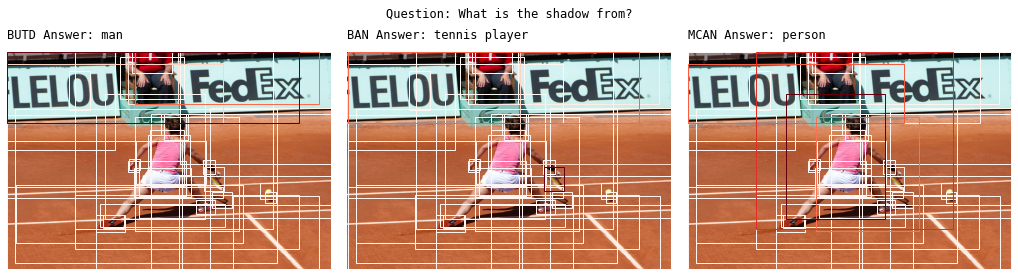

In [14]:
visualize_bbox_random(all_diff_df)

## Counting

some attentions are wrong too

- 4002
- 153785
- 157295
- 181344
- 252601
- 259762
- 262809
- 321649
- 439527

In [15]:
how_many = all_diff_df['question'].str.lower().str.contains('how many')
how_many_df = all_diff_df[how_many]
print(len(how_many_df), '"how many" questions')

5178 "how many" questions


133786


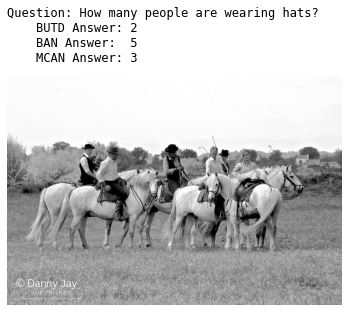

In [16]:
visualize_ques_ans_random(how_many_df)

## Common sense

- 36565
- 59774
- 62958
- 147692
- 160484
- 242620
- 315893
- 317356
- 318148
- 416298